In [83]:
%autosave 100
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Autosaving every 100 seconds


In [52]:
def f(x, s, r, b):
    return np.array([-s*x[0] + s*x[1], -x[0]*x[2] + r*x[0]-x[1], x[0]*x[1]-b*x[2]])

# Явный метод Эйлера
def euler_1(x, s, r, b, d, steps = 100):
    ans = np.empty([steps, 3], dtype = float)
    ans[0] = x
    for i in range(1, steps):
        ans[i] = ans[i - 1] + f(ans[i - 1], s, r, b) * d
    return ans

def get_env(x, d, steps):
    return cartesian_product(np.linspace(x[0] - d, x[0] + d, steps),
                             np.linspace(x[1] - d, x[1] + d, steps),
                             np.linspace(x[2] - d, x[2] + d, steps))

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)
  
# Jacobian from numdifftools is way too slow
def diff_estimate(fun, x, f_shape, h=1e-6):
    res = np.empty([f_shape, x.shape[0]])
    for i in range(x.shape[0]):
        x[i] += h
        f_hi = fun(x)
        x[i] -= 2 * h
        f_lo = fun(x)
        res[:, i] = (f_hi - f_lo) / 2 / h
        x[i] += h
    return res

# НЕявный метод Эйлера + предиктор-корректор на шаге
def euler_2(x, s, r, b, d, steps = 100):
    ans = np.empty([steps, 3], dtype = float)
    ans[0] = x
    right_part = lambda x: f(x, s, r, b) * d
    
    for i in range(1, steps):
        diff = diff_estimate(right_part, ans[i - 1], 3)
        threshold = 1 - 1e-9
        norm = np.linalg.norm(diff)
        if norm < threshold:
            ans[i] = ans[i - 1] + f(ans[i - 1], s, r, b) * d
            ans[i] = ans[i - 1] + f(ans[i], s, r, b) * d
        else:
            raise Exception('Euler did not converge due to large step. Step should be <= ', threshold / norm * d)
    return ans

# Метод Рунге-Кутта
def runge_kutta(x, s, r, b, d, steps = 100, step = 100):
    ans = np.empty([steps, 3], dtype = float)
    ans[0] = x
    for i in range(1, steps):
        tmp = np.empty([step + 1, 3], dtype = float)
        tmp[0] = ans[i - 1]
        dd = d / step
        for j in range(1, step + 1):
            tmp[j] = tmp[j - 1] + f(tmp[j - 1], s, r, b) * dd
        
        ans[i] = tmp[step] + f(tmp[step], s, r, b) * dd
    return ans

# Явный метод Адамса четвертого порядка
def adams(x, s, r, b, d, steps = 100):
    ans = np.zeros([steps, 3], dtype = float)
    ans[0] = x
    for i in range(1, 4): # Явный метод Эйлера для начальных значений
        ans[i] = ans[i - 1] + f(ans[i - 1], s, r, b) * d
    for i in range(4, steps):
        ans[i] = ans[i - 1] + (f(ans[i - 1], s, r, b) * 55 - f(ans[i - 2], s, r, b) * 59 +\
                               f(ans[i - 3], s, r, b) * 37 - f(ans[i - 4], s, r, b) * 9) * d / 24
    return ans

In [89]:
def output(ans, s, r, b, d, steps = 100):
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter(ans[:, 0], ans[:, 1], ans[:, 2], c = range(0, steps))

    ax.scatter(0, 0, 0, c = 'red', s = 20)
    if r > 1: 
        ax.scatter(math.sqrt(b * (r - 1)), math.sqrt(b * (r - 1)), r - 1, c = 'red', s = 20)
    if r > 1: 
        ax.scatter(-math.sqrt(b * (r - 1)), -math.sqrt(b * (r - 1)), r - 1, c = 'red', s = 20)

    ax.text(0, 0, 0,'v1')
    if r > 1: 
        ax.text(math.sqrt(b * (r - 1)), math.sqrt(b * (r - 1)), r - 1, 'v2')
    if r > 1: 
        ax.text(-math.sqrt(b * (r - 1)), -math.sqrt(b * (r - 1)), r - 1,  'v3')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(np.arange(0, d * steps, d), ans[:, 0], s = 10, c = range(0, steps))
    plt.xlabel('Time')
    plt.ylabel('X')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(np.arange(0, d * steps, d), ans[:, 1], s = 10, c = range(0, steps))
    plt.xlabel('Time')
    plt.ylabel('Y')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(np.arange(0, d * steps, d), ans[:, 2], s = 10, c = range(0, steps))
    plt.xlabel('Time')
    plt.ylabel('Z')
    plt.show()

In [85]:
def run_and_plot(method_name, method_fun, x, *params):
    print(method_name)
    try:
        ans = method_fun(x, *params)
        output(ans, *params)
    except Exception as e:
        print(str(e))

Явный метод Эйлера


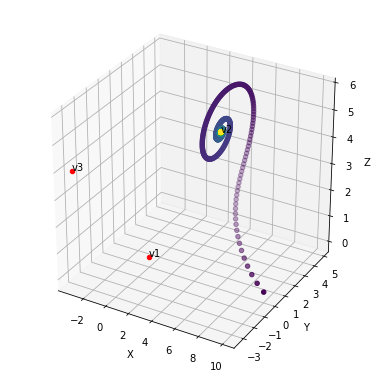

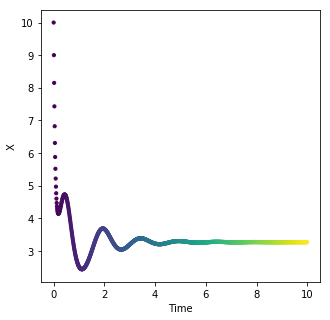

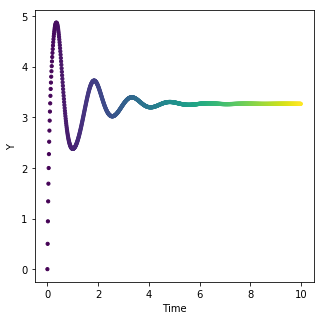

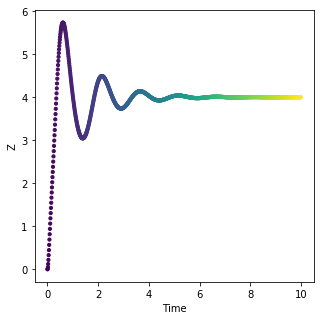

НЕявный метод Эйлера


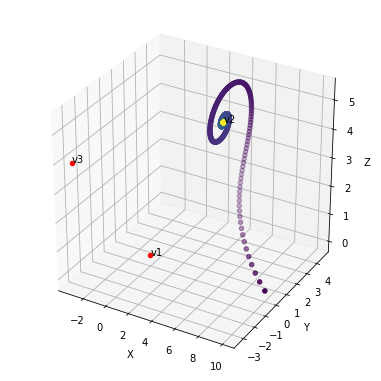

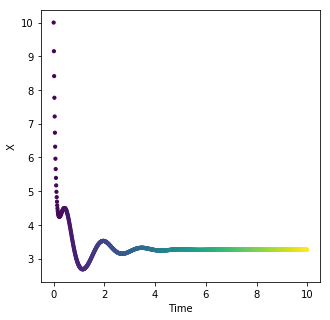

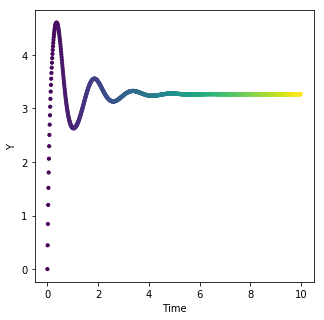

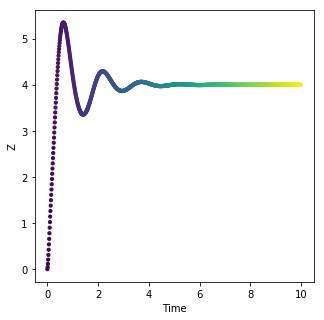

Метод Рунге-Кутта


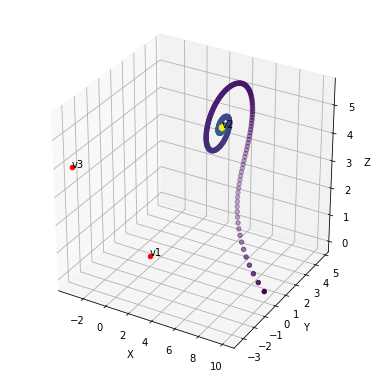

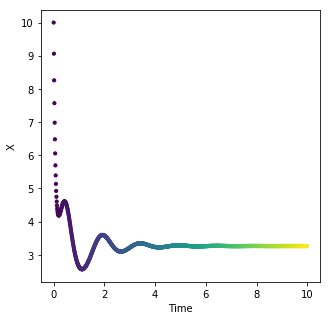

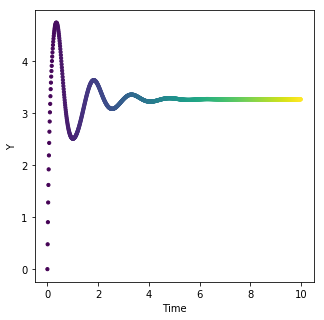

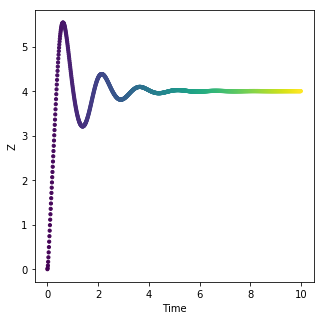

Явный метод Адамса 4 порядка


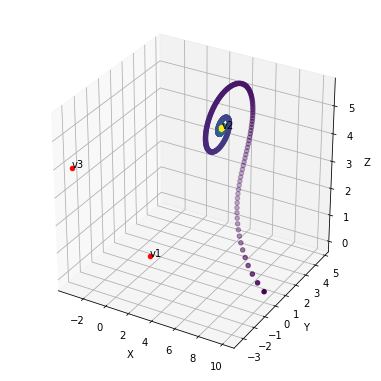

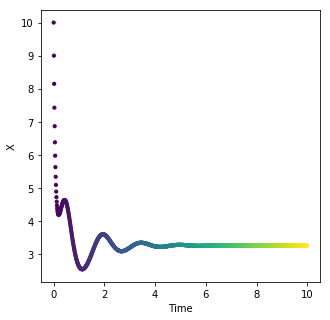

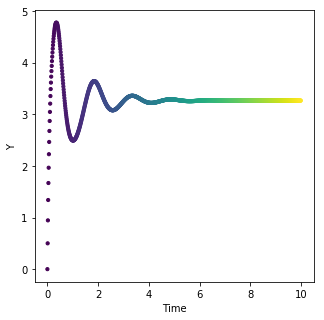

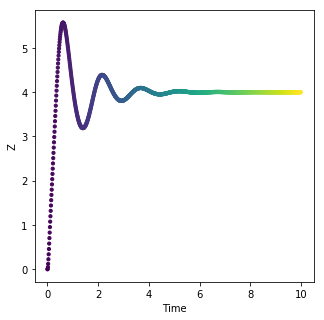

In [92]:
x = np.array([10, 0, 0])
s = 10
b = 8 / 3
r = 5
d = 0.01
steps = 1000

methods = {
    "Явный метод Эйлера": euler_1, 
    "НЕявный метод Эйлера": euler_2, 
    "Метод Рунге-Кутта": runge_kutta, 
    "Явный метод Адамса 4 порядка": adams
}

for name in methods:
    run_and_plot(name, methods[name], x, s, r, b, d, steps)